In [1]:
import xarray
import pygmt
import pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [2]:
ds = xarray.open_dataset("../data/MIROC_outputs/ctrl_MIROC-COSP2.nc")

### Config

In [14]:
# variables

vname='Doppler velocity'
#vname='radar reflectivity'
#vname='terminal velocity'
#vname='vertical air motion'
#vname='Ze-Doppler'
#vname='Ze-terminal'

In [ ]:
# meridional zone

zone='tropics'
#zone='mid-north'
#zone='pol-north'
#zone='mid-south'
#zone='pol-south'

In [2]:
# cloud regime
ctype='ALL'
#ctype='stratiform'
#ctype='convective'

In [17]:
# only for Doppler or terminal velocity

zonal_mean = False
#  True: zonal mean
# False: CFED

In [ ]:
# only for terminal velocity

weight_factor='reflectivity'
#weight_factor='mass'
#weight_factor='number'

#### internal process

In [3]:
%%capture
# data access

if vname=='Doppler velocity':
    var=ds['dplrw_T']
elif vname=='radar reflectivity':
    var=ds['Zef94_T']
elif vname=='terminal velocity':
    var=ds['vfall_T']
elif vname=='vertical air motion':
    var=ds['gridw_T']


In [4]:
#grids

lat=ds["latitude"].values
lon=ds["longitude"].values

temp=ds["lvtemp_grid"].values
zgrd=ds["lvdBZe_grid"].values
vgrd=ds["lvdplr_grid"].values

In [ ]:
# target region
west=0. ; east=360.

if zone=='tropics':
    south=-20.0 ; north= 20.0
elif zone=='mid-north':
    south= 20.0 ; north= 50.0
elif zone=='pol-north':
    south= 50.0 ; north= 90.0
elif zone=='mid-south':
    south=-50.0 ; north=-20.0
elif zone=='pol-south':
    south=-90.0 ; north=-50.0

In [7]:
# location mask
lon_mask = (lon >= west) & (lon <= east)
lat_mask = (lat >= south)&(lat <= north)

mask = lon_mask & lat_mask

index = np.where(mask)[0]

In [3]:
# cloud regime
if ctype=='ALL':
    regime=0
elif ctype=='stratiform':
    regime=1
elif ctype=='convective':
    regime=2

In [5]:
# moment
if weight_factor=='reflectivity':
    nmlz=1
elif weight_factor=='mass':
    nmlz=2
elif weight_factor=='number':
    nmlz=3

In [6]:
vmin = 0.
vmax = 2.0
tick = 0.2

if moment==6:
    nmlz = 1
elif moment==3:
    nmlz = 2
elif moment==0:
    nmlz = 3

In [8]:
sel = var.isel(loc=index).isel(regimeID=regime).isel(nrmlzdID=nmlz)
smpl = sel.sum(dim='loc', skipna=True).values
window = 0.2

In [9]:
nrm = window * smpl.sum(axis=1, keepdims=True)
nrm = np.broadcast_to(nrm,smpl.shape)

zero_check = (nrm < window)
cfed = np.zeros_like(smpl)

cfed[~zero_check] = smpl[~zero_check]/nrm[~zero_check]
cfed[zero_check] = np.nan

### Figure

In [11]:
%%capture
plt.figure(figsize=(8, 6))

In [10]:
jmacolors=np.array(
   [
    [242,242,242,1],#white
    [160,210,255,1],
    [ 33,140,255,1],
    [  0, 65,255,1],
    [  0,185,  0,1],
    [250,245,  0,1],
    [255,153,  0,1],
    [255, 40,  0,1],
    [180,  0,104,1],
    [ 45, 45, 45,1],
   ],dtype=np.float64
)
jmacolors[:,:3] /=256
jmacmap=ListedColormap(jmacolors)
jmacmap2=LinearSegmentedColormap.from_list("jmacmap2",colors=jmacolors)

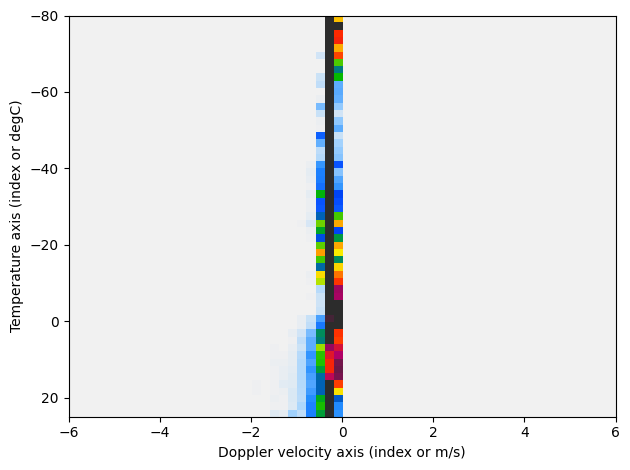

In [13]:
#extent = [x_edge[0], x_edge[-1], y_edge[-1], y_edge[0]]
extent = [ -6.0, 6.0, 25.0, -80.0 ]

im = plt.imshow(cfed,
                extent=extent,
                interpolation='nearest',
                origin='upper',
                cmap=jmacmap2,
                aspect='auto')

plt.xlabel("Doppler velocity axis (index or m/s)")
plt.ylabel("Temperature axis (index or degC)")

plt.tight_layout()
plt.show()